# Attack viz

### Table of Content

 - [Set Up](#Setup)
 - [Uniqueness investigation & Cleaning ](#cleaning)
 - [Mounting an Attack](#Mounting_an_Attack)
 - [Dependens discovery](#dependens_discovery)

## Set up <a id='Setup'></a>

In [1]:
import matplotlib
import pandas as pd
import pymysql
import random
from threading import Thread
import tqdm
%matplotlib inline

In [2]:
# Trying to read the data from the fingerpatch db
# Or if it doesnt't work from the csv
try :
    connection = pymysql.connect(host='localhost',
                             user='fingerpatch',
                             password='fingerpatch',
                             db='fingerpatch',
                             charset='utf8mb4',
                             cursorclass=pymysql.cursors.DictCursor)
    attack_table = pd.read_sql("SELECT * FROM `ubuntu_captures` ",connection)
    ground_truth = pd.read_sql("SELECT * FROM `ubuntu_packets` ",connection)
    connection.close()

except :
    
    print("No db found, loading from CSV Files")
    
    ground_truth = pd.read_csv("../crawl/ubuntu_packets.csv")
    attack_table = pd.read_csv("../capture/ubuntu_captures.csv")


ground_truth = ground_truth.set_index("id") 
attack_table = attack_table.set_index("capture_id")

No db found, loading from CSV Files


<a id='cleaning'></a>
## Uniqueness investigation & Cleaning 


Select interesting columns and remove duplicated rows

In [3]:
ground_truth.columns

Index(['capture_id', 'Package', 'Version', 'Architecture', 'Size',
       'Installed-Size', 'Priority', 'Maintainer', 'SHA1', 'Description',
       'parsedFrom', 'Description-md5', 'Bugs', 'Origin', 'MD5sum', 'Depends',
       'Homepage', 'Source', 'SHA256', 'Section', 'Supported', 'Filename',
       'packageMode'],
      dtype='object')

In [4]:
print("Total entries without having cleaned: ", len(ground_truth))

Total entries without having cleaned:  128148


In [5]:
# Selecting only interessting fields i.e. the attacker has no mean to distinguish two packages that have the same size but different packageMode
ground_truth = ground_truth.drop_duplicates(['Package', 'Version', 'Size', 'Depends', 'Architecture'])

# Make sure that there is no duplicate information (For a given Package name and Version we have at most one match)
print("The maximum duplication of rows that have the same Package name and Version is: ", ground_truth.groupby(by=["Package", "Version"]).count()["SHA1"].max())

# Selecting only interessting columns
ground_truth = ground_truth.drop(axis= 1, columns=['capture_id','SHA1', 'Priority', 'Description-md5', 'MD5sum', 'SHA256', 'packageMode' ])

ground_truth = ground_truth.fillna("")
print("Total entries after having cleaned: ", len(ground_truth))

The maximum duplication of rows that have the same Package name and Version is:  1
Total entries after having cleaned:  56997


<a id='Mounting_an_Attack'></a>
## Mounting an Attack for matching a specific capture to a package.
##### Relying on package size

In [6]:
target = attack_table.iloc[0]
target

truth_id                                                       103746
nb_flows                                                            3
HTTP_Seq            [['GET /ubuntu/pool/universe/o/opennebula/libo...
Flow1                                   target->yukinko.canonical.com
Flow2                                   yukinko.canonical.com->target
Flow3                                   target->yukinko.canonical.com
Flow4                                                             NaN
Flow5                                                             NaN
nb_Payload_send1                                                    0
nb_Payload_send2                                                67874
nb_Payload_send3                                                  173
nb_Payload_send4                                                  NaN
nb_Payload_send5                                                  NaN
Name: 1, dtype: object

In [7]:
EXTRA_SIZE_AVERAGE = 283   # Made from stats about captured packets
EXTRA_SIZE_VARIATION = 5
size_to_match = target['nb_Payload_send2']

In [8]:
def distance_from_expected_average_size(x, size_to_match):
    return abs(size_to_match - x - EXTRA_SIZE_AVERAGE)

In [9]:
ground_truth["dist_from_expected_size"] = ground_truth["Size"].map(lambda x: distance_from_expected_average_size(x, size_to_match))

In [10]:
ground_truth.sort_values(by="dist_from_expected_size").head()

,Package,Version,Architecture,Size,Installed-Size,Maintainer,Description,parsedFrom,Bugs,Origin,Depends,Homepage,Source,Section,Supported,Filename,dist_from_expected_size
id,,,,,,,,,,,,,,,,,
39672,libopennebula-java-doc,3.4.1-4.1ubuntu1,all,67592,1194,Ubuntu Developers <ubuntu-devel-discuss@lists....,Java bindings for OpenNebula Cloud API (OCA) -...,packages/archive.ubuntu.com_ubuntu_dists_trust...,https://bugs.launchpad.net/ubuntu/+filebug,Ubuntu,,http://opennebula.org/,opennebula,universe/doc,,pool/universe/o/opennebula/libopennebula-java-...,1
41519,libshisa-dev,1.0.2-3ubuntu2,amd64,67594,385,Ubuntu Developers <ubuntu-devel-discuss@lists....,Development files for the Shishi Kerberos v5 K...,packages/archive.ubuntu.com_ubuntu_dists_trust...,https://bugs.launchpad.net/ubuntu/+filebug,Ubuntu,"libshisa0 (= 1.0.2-3ubuntu2), libshishi-dev (=...",http://www.gnu.org/software/shishi/,shishi,universe/libdevel,,pool/universe/s/shishi/libshisa-dev_1.0.2-3ubu...,3
14154,libcloog-isl-dev,0.18.2-1,amd64,67588,377,Ubuntu Developers <ubuntu-devel-discuss@lists....,Chunky Loop Generator (development files),packages/archive.ubuntu.com_ubuntu_dists_trust...,https://bugs.launchpad.net/ubuntu/+filebug,Ubuntu,"libisl-dev (>= 0.11), libgmp-dev, libcloog-isl...",http://www.CLooG.org,cloog,libdevel,9m,pool/main/c/cloog/libcloog-isl-dev_0.18.2-1_am...,3
34922,libghc-shakespeare-i18n-prof,1.0.0.2-4build1,amd64,67582,429,Ubuntu Developers <ubuntu-devel-discuss@lists....,type-based approach to internationalization; p...,packages/archive.ubuntu.com_ubuntu_dists_trust...,https://bugs.launchpad.net/ubuntu/+filebug,Ubuntu,libghc-shakespeare-i18n-dev (= 1.0.0.2-4build1...,http://hackage.haskell.org/package/shakespeare...,haskell-shakespeare-i18n,universe/haskell,,pool/universe/h/haskell-shakespeare-i18n/libgh...,9
26685,gkrellmoon,0.6-5,amd64,67578,320,Ubuntu MOTU Developers <ubuntu-motu@lists.ubun...,Gkrellm Moon Clock Plugin,packages/archive.ubuntu.com_ubuntu_dists_trust...,https://bugs.launchpad.net/ubuntu/+filebug,Ubuntu,"gkrellm (>= 2.0.0), libatk1.0-0 (>= 1.13.2), l...",,,universe/x11,,pool/universe/g/gkrellmoon/gkrellmoon_0.6-5_am...,13


The first one is the one.

In [11]:
target

truth_id                                                       103746
nb_flows                                                            3
HTTP_Seq            [['GET /ubuntu/pool/universe/o/opennebula/libo...
Flow1                                   target->yukinko.canonical.com
Flow2                                   yukinko.canonical.com->target
Flow3                                   target->yukinko.canonical.com
Flow4                                                             NaN
Flow5                                                             NaN
nb_Payload_send1                                                    0
nb_Payload_send2                                                67874
nb_Payload_send3                                                  173
nb_Payload_send4                                                  NaN
nb_Payload_send5                                                  NaN
Name: 1, dtype: object

<a id='dependens_discovery'></a>
## Dependens discovery

let's take only the packages that have only one depends.

Sort them by ascending size

In [12]:
ground_truth = ground_truth.fillna("")
ground_truth["#Depends"] = ground_truth["Depends"].map(lambda x: 0 if x == "" else len(x.split(",")))
one_dep_first10 = ground_truth[ground_truth["#Depends"] == 1].sort_values(by = "Size", ascending=True)[:10]

In [13]:
one_dep_first10.iloc[0]

Package                                                              readpst
Version                                                       0.6.59-1build1
Architecture                                                             all
Size                                                                     796
Installed-Size                                                            21
Maintainer                 Ubuntu Developers <ubuntu-devel-discuss@lists....
Description                    Converts Outlook PST files to mbox and others
parsedFrom                 packages/archive.ubuntu.com_ubuntu_dists_trust...
Bugs                              https://bugs.launchpad.net/ubuntu/+filebug
Origin                                                                Ubuntu
Depends                                                            pst-utils
Homepage                                  http://www.five-ten-sg.com/libpst/
Source                                                                libpst

Seeking about that depends

In [14]:
ground_truth[ground_truth["Package"] == one_dep_first10.iloc[0]["Depends"]]

,Package,Version,Architecture,Size,Installed-Size,Maintainer,Description,parsedFrom,Bugs,Origin,Depends,Homepage,Source,Section,Supported,Filename,dist_from_expected_size,#Depends
id,,,,,,,,,,,,,,,,,,
18280,pst-utils,0.6.59-1build1,amd64,62092,181,Ubuntu Developers <ubuntu-devel-discuss@lists....,tools for reading Microsoft Outlook PST files,packages/archive.ubuntu.com_ubuntu_dists_trust...,https://bugs.launchpad.net/ubuntu/+filebug,Ubuntu,"libc6 (>= 2.14), libgcc1 (>= 1:4.1.1), libgd3 ...",http://www.five-ten-sg.com/libpst/,libpst,utils,9m,pool/main/libp/libpst/pst-utils_0.6.59-1build1...,5499,7


Turns out that this Dependens also have its Dependances

In [15]:
sub_dependances = ground_truth[ground_truth["Package"] == one_dep_first10.iloc[0]["Depends"]].iloc[0]["Depends"]
print(sub_dependances)

libc6 (>= 2.14), libgcc1 (>= 1:4.1.1), libgd3 (>= 2.1.0~alpha~), libglib2.0-0 (>= 2.12.0), libgsf-1-114 (>= 1.14.8), libpst4 (>= 0.6.54), libstdc++6 (>= 4.6)


#### Once Downloading the package `readpst` we can ideed see that the package doesn't just depends on one single package but many subpackages from that dependance:

On the Docker:

`The following extra packages will be installed:
  fontconfig-config fonts-dejavu-core libfontconfig1 libfreetype6 libgd3
  libglib2.0-0 libglib2.0-data libgsf-1-114 libgsf-1-common libjbig0
  libjpeg-turbo8 libjpeg8 libpst4 libtiff5 libvpx1 libx11-6 libx11-data
  libxau6 libxcb1 libxdmcp6 libxml2 libxpm4 pst-utils sgml-base
  shared-mime-info xml-core`
  
`0 upgraded, 27 newly installed, 0 to remove and 32 not upgraded.
Need to get 5664 kB of archives.`


On the attacker:

`historic =  ['target->danava.canonical.com', 'danava.canonical.com->target', 'target->danava.canonical.com']
server_ip =  ['91.189.88.149', '172.100.0.100', '91.189.88.149']
server_name =  ['danava.canonical.com', 'target', 'danava.canonical.com']
received_Payload =  [5671834]
send_Payload =  [0, 4251]`

So if we calculate with the tipical extra_size for each downloaded package that we get on the attacker side and knowing that 5664kB is rounded:


In [16]:
EXTRA_SIZE_AVERAGE * 27 + 5664000

5671641

#### Let's find out what happens if we download the dependance before  

While downloading pst-utils (*using apt-get install readpst*):

On the victim:

`The following extra packages will be installed:
  fontconfig-config fonts-dejavu-core libfontconfig1 libfreetype6 libgd3
  libglib2.0-0 libglib2.0-data libgsf-1-114 libgsf-1-common libjbig0
  libjpeg-turbo8 libjpeg8 libpst4 libtiff5 libvpx1 libx11-6 libx11-data
  libxau6 libxcb1 libxdmcp6 libxml2 libxpm4 sgml-base shared-mime-info
  xml-core
0 upgraded, 26 newly installed, 0 to remove and 32 not upgraded.
Need to get 5663 kB of archives.`


On the Attacker:

`historic =  ['target->keeton.canonical.com', 'keeton.canonical.com->target', 'target->keeton.canonical.com']
server_ip =  ['91.189.88.161', '172.100.0.100', '91.189.88.161']
server_name =  ['keeton.canonical.com', 'target', 'keeton.canonical.com']
received_Payload =  [5670760]
send_Payload =  [0, 4085]
Ressources cleaned.`


In [17]:
print(" -- Seen By the Attacker -- Difference by downloading the full package and only it's dependances :",5671834 - 5670760)
print(" -- For the ground_truth -- Difference by downloading the full package and only it's dependances :",796 + EXTRA_SIZE_AVERAGE)

 -- Seen By the Attacker -- Difference by downloading the full package and only it's dependances : 1074
 -- For the ground_truth -- Difference by downloading the full package and only it's dependances : 1079


Now that the dependance is installed on the vicitim's machine, we perfom the update of the principal package:


On the victim:

`The following NEW packages will be installed:
  readpst
0 upgraded, 1 newly installed, 0 to remove and 32 not upgraded.
Need to get 796 B of archives.
After this operation, 21.5 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu/ trusty/universe readpst all 0.6.59-1build1 [796 B]
Fetched 796 B in 0s (3656 B/s)   
Download complete and in download only mode`

On the attacker

`historic =  ['target->steelix.canonical.com', 'steelix.canonical.com->target', 'target->steelix.canonical.com']
server_ip =  ['91.189.88.152', '172.100.0.100', '91.189.88.152']
server_name =  ['steelix.canonical.com', 'target', 'steelix.canonical.com']
received_Payload =  [1074]
send_Payload =  [0, 155]`


Indeed, once the dependance is installed, installing just the package 

In [18]:
1074 - 796

278

### SumOfDependences & NumberOfDependances

In [19]:
one_dep_first10.iloc[1]

Package                                                                 gcom
Version                                                               0.32-2
Architecture                                                             all
Size                                                                     820
Installed-Size                                                            20
Maintainer                 Ubuntu Developers <ubuntu-devel-discuss@lists....
Description                     datacard control tool - transitional package
parsedFrom                 packages/archive.ubuntu.com_ubuntu_dists_trust...
Bugs                              https://bugs.launchpad.net/ubuntu/+filebug
Origin                                                                Ubuntu
Depends                                                                comgt
Homepage                                           http://www.pharscape.org/
Source                                                                 comgt

In [20]:
ground_truth[ground_truth["Package"] == "comgt"]

,Package,Version,Architecture,Size,Installed-Size,Maintainer,Description,parsedFrom,Bugs,Origin,Depends,Homepage,Source,Section,Supported,Filename,dist_from_expected_size,#Depends
id,,,,,,,,,,,,,,,,,,
23140,comgt,0.32-2,amd64,42804,188,Ubuntu Developers <ubuntu-devel-discuss@lists....,Option GlobeTrotter and Vodafone datacard cont...,packages/archive.ubuntu.com_ubuntu_dists_trust...,https://bugs.launchpad.net/ubuntu/+filebug,Ubuntu,libc6 (>= 2.7),http://www.pharscape.org/,,universe/net,,pool/universe/c/comgt/comgt_0.32-2_amd64.deb,24787,1


In [21]:
ground_truth[ground_truth["Package"] == "libc6"]

,Package,Version,Architecture,Size,Installed-Size,Maintainer,Description,parsedFrom,Bugs,Origin,Depends,Homepage,Source,Section,Supported,Filename,dist_from_expected_size,#Depends
id,,,,,,,,,,,,,,,,,,
1784,libc6,2.19-0ubuntu6.14,amd64,4752538,10508,Ubuntu Developers <ubuntu-devel-discuss@lists....,Embedded GNU C Library: Shared libraries,packages/archive.ubuntu.com_ubuntu_dists_trust...,https://bugs.launchpad.net/ubuntu/+filebug,Ubuntu,libgcc1,http://www.eglibc.org,eglibc,libs,5y,pool/main/e/eglibc/libc6_2.19-0ubuntu6.14_amd6...,4684947,1
14033,libc6,2.19-0ubuntu6,amd64,4729214,10496,Ubuntu Developers <ubuntu-devel-discuss@lists....,Embedded GNU C Library: Shared libraries,packages/archive.ubuntu.com_ubuntu_dists_trust...,https://bugs.launchpad.net/ubuntu/+filebug,Ubuntu,libgcc1,http://www.eglibc.org,eglibc,libs,5y,pool/main/e/eglibc/libc6_2.19-0ubuntu6_amd64.deb,4661623,1


Dependances can be ambigious

In [22]:
print(ground_truth["Depends"].iloc[48])
print(ground_truth["Depends"].iloc[405])

python (>= 2.7), python (<< 2.8), python:any (>= 2.7.1-0ubuntu2), base-files (>= 4.0.4)
python-bzrlib (<= 2.6.0+bzr6593-1ubuntu1.6.1~), python-bzrlib (>= 2.6.0+bzr6593-1ubuntu1.6), python:any


### Before implementing the recursivity function, we consatated following issues:
    - Going through dependances can lead to cycles (ex: comgt->libc6->libgcc1->libc6)
        => Can be fixed by keeping a list of seen dependances
        
    - Many packages with different version can occure (ex: libc6 2.19-0ubuntu6.14 & 2.19-0ubuntu6 not same size)
        => Maybe take the most recent one (To gain some time keep only the newest version beforehand)
        
    - Some packet are already installed by default (like libc6 in our victim's machin)
    
    - Dependances can be ambigious (ex: python (>= 2.7), python (<< 2.8), python:any (>= 2.7.1-0ubuntu2) )
        => Parsing the dependances has to be made carefully 
 
 Some references:
 
 [Depends field format](https://www.debian.org/doc/debian-policy/ch-relationships.html)
 
 [Version field format](http://www.fifi.org/doc/debian-policy/policy.html/ch-versions.html)

In [23]:

def recursiveOnly(x, summing, df,alreadySeen):
    """
    Doesn't try tu reuse old results
    """
    
    xKey = x["Package"] + " : "+x["Version"]
    
    if xKey in alreadySeen:
        return (0, {})
    
    alreadySeen[xKey] = []  
    
    deps = parseAndFindDep(x["Depends"], df)
    
    if len(deps) == 0: # Touches the leaves
    
        return ( x["Size"], {xKey : []})
    
    
    for dep in deps:
        
        if dep not in alreadySeen:
            
            newX = df.loc[dep]
            s, as_ = recursiveOnly(newX, 0, df, alreadySeen)
            
                
            # Merging
            summing += s
            alreadySeen = {**as_ , **alreadySeen}
            alreadySeen[xKey] += [newX["Package"] + " : "+newX["Version"]]
    
    
    summing = summing + x["Size"]
    
    
    return (summing, alreadySeen)    
    

def computeSumOnDep(x, df):
    childrens = x["Childrens"]
    summingDep = 0
    
    # We include ourself in the children to count everything
    childrens.add(x.name)
    
    for c in childrens:
        summingDep += df.loc[c]["Size"]
    
    df.at[x.name,"Summing dependances"] = summingDep
    
    return summingDep

    
def recursiveSearchOnDep(x, df,alreadySeen, createTree = True):
  
    """ 
    x : The current data Serie, Assuming that x contains Package, Version, Depends, Size and 
        Summing dependances, Dependance traces for the dynamic approach
        
    summing : The sum of the size in Bytes
    df is the db we are performing the recursive search
    alreadySeen : Dict with the already seen packages + version"""
    
    
    
    
    childrens = set()
    xKey = x["Package"] + " : "+x["Version"]
    
    # At the end we have to fix the packages that countained loop and couldn't build proprely the childrens 
    loopers = set()
    
   # Anti loop
    if xKey in alreadySeen:
        
        # We notifiy the parent that a loop occured
        return {}, childrens, True
    

    
    deps = parseAndFindDep(x["Depends"], df)
    
    
    
    # Init the trace of the current dep.
    myDepTraces = {}
    myDepTraces[xKey] = set()
    
    if len(deps) == 0: # Touches the leaves
        
        # Fill the df 
        df.at[x.name,"Dependance traces"] = myDepTraces
        df.at[x.name, "Childrens"] = childrens

    
        return myDepTraces, childrens, []
    

    
    alreadySeen[xKey] = set()  
    
    for dep in deps:
        

        newX = df.loc[dep]
        
        
        depChildren , childrensChildren = newX["Dependance traces"], newX["Childrens"]
        newXKey = newX["Package"] + " : "+newX["Version"]
        
        depChildren = eval(str(depChildren))
    
        if len(depChildren) == 0:
            

            depChildren, childrensChildren, loop = recursiveSearchOnDep(newX, df, alreadySeen)
            
            # If we found a loop, we will have to fix it 
            if loop:
                
                loopers.add(x.name)
            
        #print("For ", dep, " we have childrens: ", childrensChildren)
        childrens = childrens.union(childrensChildren)
        childrens.add(dep)
        
        alreadySeen = {**alreadySeen, **depChildren}
        myDepTraces = {**myDepTraces, **depChildren}
        
        
        myDepTraces[xKey].add(newX["Package"] + " : "+newX["Version"])
        alreadySeen[xKey].add(newX["Package"] + " : "+newX["Version"])
                
    
    # Adding itself in the list of childrens
    childrens.add(x.name)
                

    df.at[x.name,"Dependance traces"] = myDepTraces
    df.at[x.name, "Childrens"] = childrens
    
    
    ## Fix the ones that contained loop
    """    for l in loopers:
        newX = df.loc[l]
        recursiveSearchOnDep(newX, df, {})"""
    
    return (myDepTraces, childrens, False)




    
def parseAndFindDep(depString, df):
    """
    Return a list of ubuntu_packages id w.r.t the Dataframe df 
        which represents the dependances in depString
    """
    ids = list()
    
    allPckg = df["Package"].unique()

    for d in depString.split(", "):


        for d2 in d.split(" | "):

            d2 = d2.split(" (")

            package = d2[0]

            #print(package)

            version = ""
            if len(d2) == 2:
                # We have more info about the version
                (req, version) = d2[1][:-1].split(" ")

                if req == "<<" : 
                    req = "<"
                if req == ">>":
                    req = ">"
                if req == "=":
                    req = "=="


            if package in allPckg:

                # TOFIX simple string comparison doesn't work because 2.12.4 > 2.9.3 
                package_candidates = df[df["Package"] == package].sort_values(by="Version", ascending=False)
                id_ = package_candidates.iloc[0].name

                if version != "":
                    # Restraint further more using the version spec.
                    package_candidates = package_candidates.query("Version "+req+" '"+version+"'")    

                    if len(package_candidates) > 0 :
                        # just take the most recent one if there are many versions
                        id_ = package_candidates.iloc[0].name


                # Add it only if it's the first time we add it
                if id_ not in ids:
                    ids = ids + [id_]

                # We found it no need to take the packages after "|"
                break 
                
    return ids
    

In [24]:
## Useful to see if the recursive function behave correctly on a given entry
"""
ground_truth["Summing dependances"] = -1
ground_truth["Dependance traces"] = "{}"
ground_truth["Childrens"] = ""

#recursiveSearchOnDep(ground_truth.iloc[7512], ground_truth, {})
recursiveSearchOnDep(ground_truth.loc[2077], ground_truth, {})
recursiveSearchOnDep(ground_truth.loc[1784], ground_truth, {})
#computeSumOnDep(ground_truth.loc[7428], ground_truth)
"""

'\nground_truth["Summing dependances"] = -1\nground_truth["Dependance traces"] = "{}"\nground_truth["Childrens"] = ""\n\n#recursiveSearchOnDep(ground_truth.iloc[7512], ground_truth, {})\nrecursiveSearchOnDep(ground_truth.loc[2077], ground_truth, {})\nrecursiveSearchOnDep(ground_truth.loc[1784], ground_truth, {})\n#computeSumOnDep(ground_truth.loc[7428], ground_truth)\n'

In [25]:
ground_truth["Summing dependances"] = -1
ground_truth["Dependance traces"] = "{}"
ground_truth["Childrens"] = ""

ground_truth = ground_truth.sort_values(["#Depends"])

tot = len(ground_truth)

for _, row in tqdm.tqdm(ground_truth.iterrows(), total=tot):
       
    
    myDepTraces, childrens, _ = recursiveSearchOnDep(row, ground_truth, {}) 
    
    """
    ground_truth.at[row.name,"Dependance traces"] = myDepTraces
    ground_truth.at[row.name, "Childrens"] = childrens"""



#%time test["Summing dependances"], test["Dependance traces"] = zip(*test.apply(lambda x: recursiveSearchOnDep(x, 0, test, {}), axis = 1))


100%|██████████| 56997/56997 [50:50<00:00,  1.10s/it]  


In [26]:
for _, row in tqdm.tqdm(ground_truth.iterrows(), total=tot ):
    
    summingDep = computeSumOnDep(row, ground_truth)
    ground_truth.at[row.name, "Summing dependances"] = summingDep
    
    

100%|██████████| 56997/56997 [07:22<00:00, 128.93it/s]


In [94]:
ground_truth[["Package", "Version", "Size", "Dependance traces","Elements involved","Summing dependances", "Childrens", "Frequency" ]].to_csv("cleaned_and_expanded_gt.csv")

 Timing:
 
 - ___45min___ to go over all the entries and recursively find the dependences
 - ___7.5min___ to sum the dependences
 - ___5min___ to build the all tree of dependences (see later)

In [100]:
## Saving the table for reuse.
ground_truth.to_csv("gt_with_dep.csv")
gt2 = pd.read_csv("gt_with_dep.csv").set_index("id")

##### -------------------------------------------------------- TEST SECTION ---------------------------------------------------------

In [28]:
import random
r = random.randint(0, 56997)
print(r)
ground_truth.loc[r]
#44449

9542


Package                                                                klash
Version                                          0.8.11~git20130903-3ubuntu1
Architecture                                                           amd64
Size                                                                  186636
Installed-Size                                                           602
Maintainer                 Ubuntu Developers <ubuntu-devel-discuss@lists....
Description                GNU Shockwave Flash (SWF) player - Standalone ...
parsedFrom                 packages/archive.ubuntu.com_ubuntu_dists_trust...
Bugs                              https://bugs.launchpad.net/ubuntu/+filebug
Origin                                                                Ubuntu
Depends                    gnash-common (= 0.8.11~git20130903-3ubuntu1), ...
Homepage                                  http://www.gnu.org/software/gnash/
Source                                                                 gnash

In [29]:
print("There are : " , len(ground_truth.loc[r]["Dependance traces"]), "subdependences for the Package " + ground_truth.iloc[r]["Package"])

There are :  141 subdependences for the Package sisc


The trace of the python package

In [30]:
ground_truth[ground_truth["Package"] == "python"].iloc[0]["Dependance traces"]

{'python : 2.7.5-5ubuntu3': {'libpython-stdlib : 2.7.5-5ubuntu3',
  'python-minimal : 2.7.5-5ubuntu3',
  'python2.7 : 2.7.6-8ubuntu0.4'},
 'python2.7 : 2.7.6-8ubuntu0.4': {'libpython2.7-stdlib : 2.7.6-8ubuntu0.4',
  'mime-support : 3.54ubuntu1.1',
  'python2.7-minimal : 2.7.6-8ubuntu0.4'},
 'python2.7-minimal : 2.7.6-8ubuntu0.4': {'libpython2.7-minimal : 2.7.6-8ubuntu0.4',
  'zlib1g : 1:1.2.8.dfsg-1ubuntu1.1'},
 'libpython2.7-minimal : 2.7.6-8ubuntu0.4': set(),
 'zlib1g : 1:1.2.8.dfsg-1ubuntu1.1': {'libc6 : 2.19-0ubuntu6.14'},
 'libc6 : 2.19-0ubuntu6.14': {'libgcc1 : 1:4.9.3-0ubuntu4'},
 'libgcc1 : 1:4.9.3-0ubuntu4': {'gcc-4.9-base : 4.9.3-0ubuntu4',
  'libc6 : 2.19-0ubuntu6.14'},
 'gcc-4.9-base : 4.9.3-0ubuntu4': set(),
 'libpython2.7-stdlib : 2.7.6-8ubuntu0.4': {'libbz2-1.0 : 1.0.6-5',
  'libc6 : 2.19-0ubuntu6.14',
  'libdb5.3 : 5.3.28-3ubuntu3.1',
  'libexpat1 : 2.1.0-4ubuntu1.4',
  'libffi6 : 3.1~rc1+r3.0.13-12ubuntu0.2',
  'libncursesw5 : 5.9+20140118-1ubuntu1',
  'libpython2.7-mi

In [ ]:
ground_truth[ground_truddth["Package"] == "python-minimal" ]#.iloc[0]["Depends"]

In [31]:
print("All the dependences for the package python: ")
len(ground_truth.loc[18315]["Dependance traces"].keys())

All the dependences for the package python: 


24

##### -------------------------------------------------------- END TEST SECTION ---------------------------------------------------------

#### quantifing the percentages of ___what can be done___ and ___what cannot___

1) Computing the elements involved in packages + Version.

In [32]:
# The element itself is part of 
ground_truth["Elements involved"] = ground_truth['Dependance traces'].map(lambda x: len(x))
ground_truth["Elements involved"].describe()


count    56997.000000
mean        50.217485
std         75.602141
min          1.000000
25%          6.000000
50%         20.000000
75%         64.000000
max       1109.000000
Name: Elements involved, dtype: float64

In average, we have 50.21 other dependencies involved when we match exactly one dependance each time. since the median is low, only 20.

<font color='red'>Important</font> : We are not considering multiple possibilities for one single dependance.
 (i.e. when having << we just pick the most recent version. We don't consider all the possibilites. Same for | we just pick the fisrt possible match )

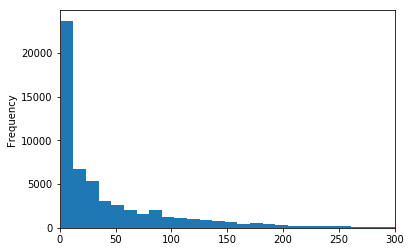

In [33]:
ground_truth["Elements involved"].plot.hist(bins = 98, xlim=[0,300])

Seems like it follows a nice exponnential distribution

In [34]:
def analyseDep(depString):
    """
    Extract interessting numbers about dependances specificaton
    """
    ids = list()
    
    eq = 0
    beq = 0
    leq = 0
    lessThan = 0
    biggerThan = 0
    alternatives = 0
    noSpec = 0
    
    

    for d in depString.split(", "):
        
        alternatives += len(d.split(" | ")) - 1
        
        for d2 in d.split(" | "):

            d2 = d2.split(" (")

            package = d2[0]

            version = ""
            if len(d2) == 2:
                # We have more info about the version
                (req, version) = d2[1][:-1].split(" ")

                if req == "<<" :
                    lessThan +=1 
                    req = "<"
                    
                if req == "<=":
                    leq +=1
                    
                if req == "=":
                    req = "=="
                    eq +=1
                    
                if req == ">=":
                    beq +=1
                    
                if req == ">>":
                    req = ">"
                    biggerThan += 1
            
            else:
                # No info about the version
                noSpec +=1
                
    return lessThan, leq, eq, beq, biggerThan, noSpec, alternatives

ground_truth["<<"], ground_truth["<="], ground_truth["="], ground_truth[">="], ground_truth[">>"], ground_truth["noSpec"], ground_truth["alternatives"] = zip(*ground_truth["Depends"].map(analyseDep))                           

In [35]:
version_spe = ground_truth[["<<", "<=", "=", ">=", ">>", "noSpec", "alternatives"]].sum()
version_spe

<<                4212
<=                  38
=                19854
>=              119179
>>                 513
noSpec           98732
alternatives     10715
dtype: int64

Using percentage we have

In [36]:
total = ground_truth[["<<", "<=", "=", ">=", ">>", "noSpec", "alternatives"]].sum().sum()
version_spe = ground_truth[["<<", "<=", "=", ">=", ">>", "noSpec", "alternatives"]].sum().map(lambda x: x/total * 100)
ground_truth[["<<", "<=", "=", ">=", ">>", "noSpec", "alternatives"]].sum().map(lambda x: "{0:.3f}%".format(x/total * 100))


<<               1.663%
<=               0.015%
=                7.840%
>=              47.061%
>>               0.203%
noSpec          38.987%
alternatives     4.231%
dtype: object

##### Visualization of the previous countities

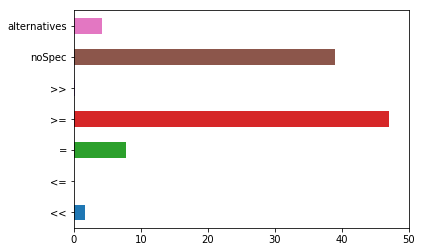

In [37]:
version_spe.plot.barh(x = "percentage", xlim = [0,50])

Here we see that the proportion of `<=` and `>>` is negligible compare to the rest. Indeed, generlly we don't specify that we want strictly higher than a specific version we will rather say this version or higher. Same applies for `<=`, we want stricly less than a specific version in general. 

The vast majority is in `>=` and no spec. 

### Building the dependances trees as a dictionnary

In [38]:
All_traces = dict()
for index, row in tqdm.tqdm(ground_truth.iterrows()):
    All_traces = {**All_traces, **row['Dependance traces']}
    


12231it [00:05, 735.84it/s] 


KeyboardInterrupt: 

In [39]:
All_traces["perl : 5.18.2-2ubuntu1.6"]

{'libbz2-1.0 : 1.0.6-5',
 'libc6 : 2.19-0ubuntu6.14',
 'libdb5.3 : 5.3.28-3ubuntu3.1',
 'libgdbm3 : 1.8.3-12build1',
 'perl-base : 5.18.2-2ubuntu1.6',
 'perl-modules : 5.18.2-2ubuntu1.6',
 'zlib1g : 1:1.2.8.dfsg-1ubuntu1.1'}

In [40]:
All_traces["zlib1g : 1:1.2.8.dfsg-1ubuntu1.1"]

{'libc6 : 2.19-0ubuntu6.14'}

In [41]:
All_traces["libc6 : 2.19-0ubuntu6.14"]

{'libgcc1 : 1:4.9.3-0ubuntu4'}

In [42]:
All_traces['libgcc1 : 1:4.9.3-0ubuntu4']

{'gcc-4.9-base : 4.9.3-0ubuntu4', 'libc6 : 2.19-0ubuntu6.14'}

In [43]:
All_traces["gcc-4.9-base : 4.9.3-0ubuntu4"]

set()

###### Top 5 of Package requiring the most # of dependences

In [44]:
ground_truth[["Package", "Version", "Size", "Dependance traces","Elements involved","Summing dependances" ]].sort_values("Elements involved", ascending=False).iloc[0:5]

,Package,Version,Size,Dependance traces,Elements involved,Summing dependances
id,,,,,,
29528,kubuntu-full,1.308,2626,{'kubuntu-full : 1.308': {'kde-runtime : 4:4.1...,1109,736776922
9612,kubuntu-full,1.308.1.2,2660,{'kubuntu-full : 1.308.1.2': {'kde-runtime : 4...,1109,736776956
26944,gnome-desktop-environment,1:3.8+4ubuntu3,3130,{'gnome-desktop-environment : 1:3.8+4ubuntu3':...,1080,453541476
26915,gnome,1:3.8+4ubuntu3,2830,{'gnome : 1:3.8+4ubuntu3': {'cheese : 3.10.2-0...,1079,453538346
54490,ubuntu-touch,1.126,2466,{'ubuntu-touch : 1.126': {'qtdeclarative5-qtmu...,1063,405727828


###### Top 5 of Package requiring the most space

In [147]:
ground_truth[["Package", "Version", "Size", "Dependance traces","Elements involved","Summing dependances" ]].sort_values("Summing dependances", ascending=False).iloc[0:5]

,Package,Version,Size,Dependance traces,Elements involved,Summing dependances
id,,,,,,
11355,texlive-full,2013.20140215-1ubuntu0.1,14542,{'texlive-full : 2013.20140215-1ubuntu0.1': {'...,281,1684150276
53769,texlive-full,2013.20140215-1,14502,{'texlive-full : 2013.20140215-1': {'texlive-f...,281,1684150236
20985,0ad-dbg,0.0.15+dfsg-3,55484348,{'0ad-dbg : 0.0.15+dfsg-3': {'0ad : 0.0.15+dfs...,165,1145821568
25283,flightgear,3.0.0-1,3834076,{'flightgear : 3.0.0-1': {'libglu1-mesa : 9.0....,268,1090723236
20982,0ad,0.0.15+dfsg-3,2561358,{'0ad : 0.0.15+dfsg-3': {'libxml2 : 2.9.1+dfsg...,164,1090337220


Let's group our list by size and by sum of dependances:

In [93]:
bySize = ground_truth.groupby(by="Size").count().groupby(by = "Package").count()
total = bySize["Version"].sum()
print(total)
bySize["Version"].map(lambda x : x/total).sort_values(ascending = False).head()

43710


Package
1    0.830611
2    0.110867
3    0.035941
4    0.012560
5    0.004850
Name: Version, dtype: float64

In [94]:
includingDep = ground_truth.groupby(by="Summing dependances").count().groupby(by = "Package").count()
total = includingDep["Version"].sum()
includingDep["Version"].map(lambda x : x/total)

Package
1    0.981139
2    0.017589
3    0.000860
4    0.000233
5    0.000090
6    0.000018
7    0.000054
9    0.000018
Name: Version, dtype: float64

In [95]:
both = ground_truth["Size"].append(ground_truth["Summing dependances"])
grouped = both.groupby(both).count()
uniqueness = grouped.groupby(grouped).count().sort_values(ascending = False)
total = uniqueness.sum()
uniqueness.map(lambda x : x/total).head()

1    0.856584
2    0.106516
3    0.022322
4    0.008270
5    0.003207
dtype: float64

#### Most frequent dependences

In [49]:
d = set()
d.add("Yoo")
"Yoo" in d

True

In [ ]:

for _, row in tqdm.tqdm(ground_truth.iterrows(), total=tot ):
    
    
    d[row.name] = ground_truth["Childrens"].map(lambda childrens: row.name in childrens).sum()

    
s = pd.Series(d, name='Dependence Frequency')


In [92]:
ground_truth = ground_truth.assign( Frequency= s)
ground_truth[["Package", "Version", "Size", "Dependance traces","Elements involved","Summing dependances", "Frequency" ]].sort_values(by="Frequency", ascending=False).head(10)

,Package,Version,Size,Dependance traces,Elements involved,Summing dependances,Frequency
id,,,,,,,
751,gcc-4.9-base,4.9.3-0ubuntu4,15146,{'gcc-4.9-base : 4.9.3-0ubuntu4': {}},1,15146,48385
2077,libgcc1,1:4.9.3-0ubuntu4,39194,{'libgcc1 : 1:4.9.3-0ubuntu4': {'gcc-4.9-base ...,3,4806878,48382
1784,libc6,2.19-0ubuntu6.14,4752538,{'libc6 : 2.19-0ubuntu6.14': {'libgcc1 : 1:4.9...,3,4806878,48382
8618,zlib1g,1:1.2.8.dfsg-1ubuntu1.1,49800,{'zlib1g : 1:1.2.8.dfsg-1ubuntu1.1': {'libc6 :...,4,4856678,33164
12011,debconf,1.5.51ubuntu2,136156,{'debconf : 1.5.51ubuntu2': {}},1,136156,27592
14027,libbz2-1.0,1.0.6-5,33946,{'libbz2-1.0 : 1.0.6-5': {'libc6 : 2.19-0ubunt...,4,4840824,25507
2826,libpcre3,1:8.31-2ubuntu2.3,144410,{'libpcre3 : 1:8.31-2ubuntu2.3': {'libc6 : 2.1...,4,4951288,22205
2008,libffi6,3.1~rc1+r3.0.13-12ubuntu0.2,17864,{'libffi6 : 3.1~rc1+r3.0.13-12ubuntu0.2': {'li...,4,4824742,22112
3162,libselinux1,2.2.2-1ubuntu0.1,58690,{'libselinux1 : 2.2.2-1ubuntu0.1': {'libpcre3 ...,5,5009978,21588


In [93]:
ground_truth["Frequency"].describe()

count    56997.000000
mean        50.236030
std        700.517587
min          1.000000
25%          1.000000
50%          1.000000
75%          3.000000
max      48385.000000
Name: Frequency, dtype: float64

In [97]:
ground_truth["Freq in %"] = ground_truth["Frequency"].map(lambda x : x/len(ground_truth) )

In [99]:
ground_truth[["Package", "Version", "Size", "Dependance traces","Elements involved","Summing dependances", "Freq in %" ]].sort_values(by="Freq in %", ascending=False).head(10)

,Package,Version,Size,Dependance traces,Elements involved,Summing dependances,Freq in %
id,,,,,,,
751,gcc-4.9-base,4.9.3-0ubuntu4,15146,{'gcc-4.9-base : 4.9.3-0ubuntu4': {}},1,15146,0.848904
2077,libgcc1,1:4.9.3-0ubuntu4,39194,{'libgcc1 : 1:4.9.3-0ubuntu4': {'gcc-4.9-base ...,3,4806878,0.848852
1784,libc6,2.19-0ubuntu6.14,4752538,{'libc6 : 2.19-0ubuntu6.14': {'libgcc1 : 1:4.9...,3,4806878,0.848852
8618,zlib1g,1:1.2.8.dfsg-1ubuntu1.1,49800,{'zlib1g : 1:1.2.8.dfsg-1ubuntu1.1': {'libc6 :...,4,4856678,0.581855
12011,debconf,1.5.51ubuntu2,136156,{'debconf : 1.5.51ubuntu2': {}},1,136156,0.484096
14027,libbz2-1.0,1.0.6-5,33946,{'libbz2-1.0 : 1.0.6-5': {'libc6 : 2.19-0ubunt...,4,4840824,0.447515
2826,libpcre3,1:8.31-2ubuntu2.3,144410,{'libpcre3 : 1:8.31-2ubuntu2.3': {'libc6 : 2.1...,4,4951288,0.389582
2008,libffi6,3.1~rc1+r3.0.13-12ubuntu0.2,17864,{'libffi6 : 3.1~rc1+r3.0.13-12ubuntu0.2': {'li...,4,4824742,0.387950
3162,libselinux1,2.2.2-1ubuntu0.1,58690,{'libselinux1 : 2.2.2-1ubuntu0.1': {'libpcre3 ...,5,5009978,0.378757


In [107]:
f1 = len(ground_truth[ground_truth["Freq in %"] > 0.05])
f2 = len(ground_truth[ground_truth["Freq in %"] > 0.1])
f3 = len(ground_truth[ground_truth["Freq in %"] > 0.15])
f4 = len(ground_truth[ground_truth["Freq in %"] > 0.2])


print("{} Package Involved in more than 5% ".format(f1))
print("{} Package Involved in more than 10% ".format(f2))
print("{} Package Involved in more than 15% ".format(f3))
print("{} Package Involved in more than 20% ".format(f4))

208 Package Involved in more than 5% 
139 Package Involved in more than 10% 
77 Package Involved in more than 15% 
57 Package Involved in more than 20% 
